In [5]:
import numpy as np
import math
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import math
from argparse import Namespace
from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

from finetune_exp import *

In [6]:
opt = Namespace(num_train=2000, num_val1=1000, num_val2=500, num_test=1000)

In [7]:
from scipy.stats import multivariate_normal

def multi_gaussian_pdf(x, mu, sigma):
    return multivariate_normal.pdf(x, mean=mu, cov=sigma)

def data_gen(ypos_p, zpos_coef):
    cov_y_0 = np.array([[10, 1], [1, 3]])
    cov_y_1 = np.array([[5, 1], [1, 5]])
    mu_y_0 = np.array([-2, -2])
    mu_y_1 = np.array([2, 2])

    N_test = 7000
    X_test = np.zeros((N_test, 2))
    y_test = np.zeros((N_test))
    s1_test = np.zeros((N_test))

    for i in range(N_test):
        if np.random.rand() < 1 - ypos_p:
            X_test[i, :] = np.random.multivariate_normal([-2, -2], [[10, 1], [1, 3]])
            y_test[i] = -1
        else:
            X_test[i, :] = np.random.multivariate_normal([2, 2], [[5, 1], [1, 5]])
            y_test[i] = 1
        x_prime_1 = X_test[i, 0] * math.cos(math.pi/4) + X_test[i, 1] * math.sin(math.pi/4)
        x_prime_2 = - X_test[i, 0] * math.sin(math.pi/4) + X_test[i, 1] * math.cos(math.pi/4)
        p_z_1 = multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_1, cov_y_1) / \
                (multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_0, cov_y_0) + \
                multi_gaussian_pdf([x_prime_1, x_prime_2], mu_y_1, cov_y_1))
        if np.random.rand() < p_z_1 * zpos_coef:
            s1_test[i] = 1
        else:
            s1_test[i] = 0
    return X_test, y_test, s1_test

In [11]:
imbalance_test_res = []
trial_num = 10

opt = Namespace(num_train=1800, num_val1=200, num_val2=1000, num_test=1000)
num_train = opt.num_train
num_val1 = opt.num_val1
num_val2 = opt.num_val2
num_test = opt.num_test

lambda_f_lst = [0.7, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99]
lambda_r_lst = [0.05]

for ypos_p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for zpos_coef in [0.6, 1, 1.4]:
        for trial in range(trial_num):
            seed = int(trial + 100 * ypos_p + 1000 * zpos_coef)
            np.random.seed(seed)
            X, y, s1 = data_gen(ypos_p, zpos_coef)
            X = torch.FloatTensor(X)
            y = torch.FloatTensor(y)
            s1 = torch.FloatTensor(s1)

            X_train = X[:num_train]
            y_train = y[:num_train] 
            s1_train = s1[:num_train]

            X_clean = X[num_train: num_train + num_val1]
            y_clean = y[num_train: num_train + num_val1]
            s1_clean = s1[num_train: num_train + num_val1]

            X_val = X[num_train + num_val1 : num_train + num_val1 + num_val2]
            y_val = y[num_train + num_val1 : num_train + num_val1 + num_val2]
            s1_val = s1[num_train + num_val1 : num_train + num_val1 + num_val2]

            X_test = X[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
            y_test = y[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]
            s1_test = s1[num_train + num_val1 + num_val2 : num_train + num_val1 + num_val2 + num_test]

            XS_train = torch.cat([X_train, s1_train.reshape((s1_train.shape[0], 1))], dim=1)
            XS_clean = torch.cat([X_clean, s1_clean.reshape((s1_clean.shape[0], 1))], dim=1)
            XS_val = torch.cat([X_val, s1_val.reshape((s1_val.shape[0], 1))], dim=1)
            XS_test = torch.cat([X_test, s1_test.reshape((s1_test.shape[0], 1))], dim=1)
            
            train_tensors = Namespace(XS_train = XS_train, y_train = y_train, s1_train = s1_train)
            clean_tensors = Namespace(XS_clean = XS_clean, y_clean = y_clean, s1_clean = s1_clean)
            val_tensors = Namespace(XS_val = XS_val, y_val = y_val, s1_val = s1_val)
            test_tensors = Namespace(XS_test = XS_test, y_test = y_test, s1_test = s1_test)
            
            _, best_params, test_acc, test_di = finetune_performance(train_tensors, clean_tensors, val_tensors, test_tensors, lambda_f_lst, lambda_r_lst, seed=seed)
            imbalance_test_res.append([ypos_p, zpos_coef, trial, best_params, test_acc, test_di])
            print('ypos_p: {}, zpos_coef: {}, trial: {}, test_acc: {}, test_di: {}'.format(ypos_p, zpos_coef, trial, test_acc, test_di))
        
imbalance_test_res = pd.DataFrame(imbalance_test_res, columns=['ypos_p', 'zpos_coef', 'trial', 'best_params', 'test_acc', 'test_di'])
imbalance_test_res.to_csv('imbalance_test_res_exp.csv', index=False)

ypos_p: 0.1, zpos_coef: 0.6, trial: 0, test_acc: 0.9470000267028809, test_di: 0.8813559322033899
ypos_p: 0.1, zpos_coef: 0.6, trial: 1, test_acc: 0.9330000281333923, test_di: 0.647084564052073
ypos_p: 0.1, zpos_coef: 0.6, trial: 2, test_acc: 0.8859999775886536, test_di: 0.8390092879256966
ypos_p: 0.1, zpos_coef: 0.6, trial: 3, test_acc: 0.8529999852180481, test_di: 0.9677450260275285
ypos_p: 0.1, zpos_coef: 0.6, trial: 4, test_acc: 0.9430000185966492, test_di: 0.5188724319159101
ypos_p: 0.1, zpos_coef: 0.6, trial: 5, test_acc: 0.9330000281333923, test_di: 0.6708020050125313
ypos_p: 0.1, zpos_coef: 0.6, trial: 6, test_acc: 0.890999972820282, test_di: 0.8716104497354497
ypos_p: 0.1, zpos_coef: 0.6, trial: 7, test_acc: 0.9290000200271606, test_di: 0.8360976883897088
ypos_p: 0.1, zpos_coef: 0.6, trial: 8, test_acc: 0.8420000076293945, test_di: 0.9617265793344051
ypos_p: 0.1, zpos_coef: 0.6, trial: 9, test_acc: 0.9459999799728394, test_di: 0.9496166484118291
ypos_p: 0.1, zpos_coef: 1, trial

In [12]:
imbalance_test_res

,ypos_p,zpos_coef,trial,best_params,test_acc,test_di
0,0.1,0.6,0,"[0.95, 0.05]",0.947,0.881356
1,0.1,0.6,1,"[0.9, 0.05]",0.933,0.647085
2,0.1,0.6,2,"[0.95, 0.05]",0.886,0.839009
3,0.1,0.6,3,"[0.99, 0.05]",0.853,0.967745
4,0.1,0.6,4,"[0.9, 0.05]",0.943,0.518872
...,...,...,...,...,...,...
265,0.9,1.4,5,"[0.8, 0.05]",0.928,0.919213
266,0.9,1.4,6,"[0.8, 0.05]",0.912,0.908192
267,0.9,1.4,7,"[0.8, 0.05]",0.912,0.913731
268,0.9,1.4,8,"[0.7, 0.05]",0.934,0.924265


In [13]:
imbalance_test_res_agg = imbalance_test_res.groupby(['ypos_p', 'zpos_coef']).agg({'test_acc': ['mean', 'std'], 'test_di': ['mean', 'std']}).reset_index()
imbalance_test_res_agg.columns = ['ypos_p', 'zpos_coef', 'test_acc_mean', 'test_acc_std', 'test_di_mean', 'test_di_std']
imbalance_test_res_agg.head()

,ypos_p,zpos_coef,test_acc_mean,test_acc_std,test_di_mean,test_di_std
0,0.1,0.6,0.9103,0.039415,0.814392,0.152128
1,0.1,1.0,0.9154,0.012331,0.708647,0.104615
2,0.1,1.4,0.8960,0.035487,0.741665,0.173297
3,0.2,0.6,0.8605,0.048063,0.858421,0.108801
4,0.2,1.0,0.7900,0.083461,0.883107,0.116414


In [14]:
imbalance_test_res_agg.rename(columns={'zpos_coef': 'c'}, inplace=True)

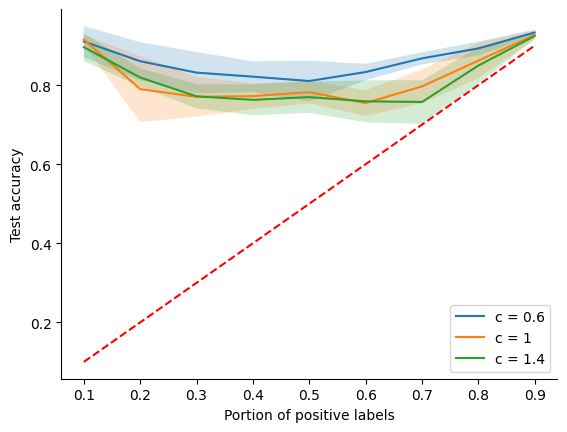

In [20]:
from matplotlib import pyplot as plt

plt.plot([0.1, 0.9], [0.1, 0.9], 'r--')
# plt.plot([0.1, 0.5], [0.9, 0.5], 'r--')
for coef in [0.6, 1, 1.4]:
    ypos_p = imbalance_test_res_agg[imbalance_test_res_agg['c'] == coef]['ypos_p'].values
    mean = imbalance_test_res_agg[imbalance_test_res_agg['c'] == coef]['test_acc_mean'].values
    std = imbalance_test_res_agg[imbalance_test_res_agg['c'] == coef]['test_acc_std'].values
    # plot the mean and the confidence interval by shading the area
    plt.plot(ypos_p, mean, label='c = {}'.format(coef))
    plt.fill_between(ypos_p, mean - std, mean + std, alpha=0.2)

plt.legend()
plt.xlabel('Portion of positive labels')
plt.ylabel('Test accuracy')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

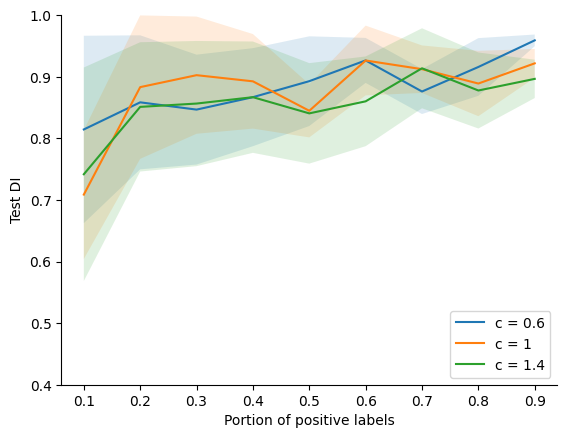

In [19]:
color_4 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# do the same for test_di
for coef in [0.6, 1, 1.4]:
    ypos_p = imbalance_test_res_agg[imbalance_test_res_agg['c'] == coef]['ypos_p'].values
    mean = imbalance_test_res_agg[imbalance_test_res_agg['c'] == coef]['test_di_mean'].values
    std = imbalance_test_res_agg[imbalance_test_res_agg['c'] == coef]['test_di_std'].values
    # plot like a series of boxplot
    plt.plot(ypos_p, mean, label='c = {}'.format(coef))
    plt.fill_between(ypos_p, mean - std, mean + std, alpha=0.15)
    
plt.xlabel('Portion of positive labels')
plt.ylabel('Test DI')
plt.ylim([0.4, 1])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc = 'lower right')

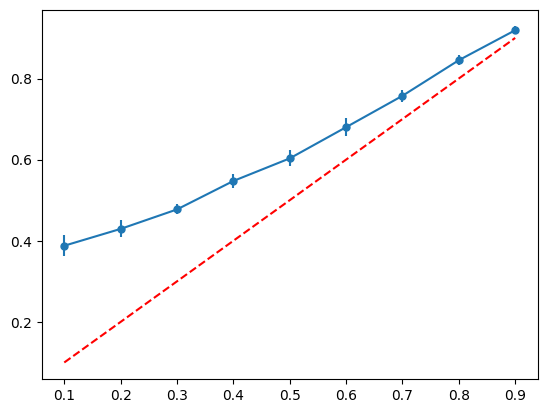

In [16]:
zpos_p1 = imbalance_test_res_agg[imbalance_test_res_agg['zpos_coef'] == 1]
plt.errorbar(zpos_p1['ypos_p'], zpos_p1['test_acc_mean'], yerr=zpos_p1['test_acc_std'], label='test_acc', capsize=0,  marker='o', markersize=5)
# plot the diagonal line dash
plt.plot([0.1, 0.9], [0.1, 0.9], 'r--')

<ErrorbarContainer object of 3 artists>

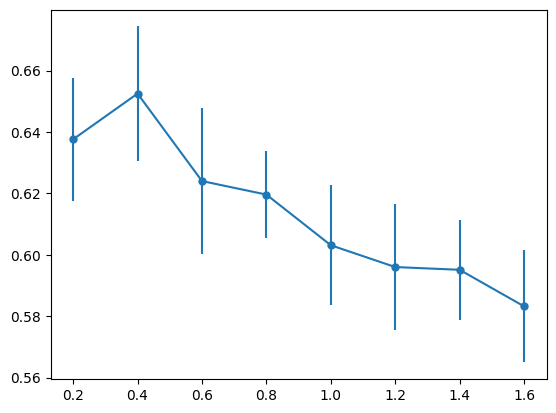

In [18]:
# plot zpos_coef against test_acc
ypos_p_05 = imbalance_test_res_agg[imbalance_test_res_agg['ypos_p'] == 0.5]
plt.errorbar(ypos_p_05['zpos_coef'], ypos_p_05['test_acc_mean'], yerr=ypos_p_05['test_acc_std'], label='test_acc', capsize=0,  marker='o', markersize=5)

<ErrorbarContainer object of 3 artists>

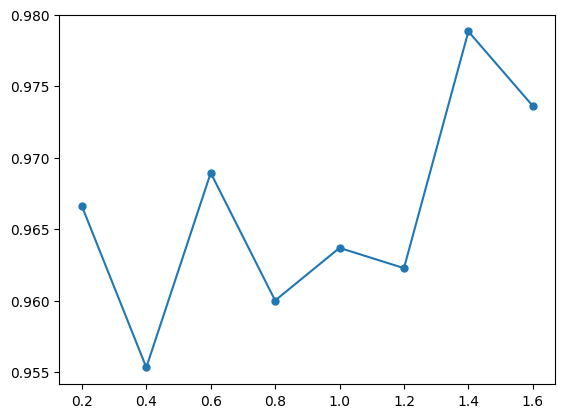

In [19]:
# plot zpos_coef against test_di
ypos_p_05 = imbalance_test_res_agg[imbalance_test_res_agg['ypos_p'] == 0.5]
plt.errorbar(ypos_p_05['zpos_coef'], ypos_p_05['test_di_mean'], label='test_di', capsize=0,  marker='o', markersize=5)